In [1]:
import os
import json
import math
import numpy as np 
import pandas as pd
import random
import sys

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  del sys.path[0]


Device: cuda:0


In [2]:
fixed_noise = torch.randn(1, 50,device=device)
fixed_noise

tensor([[ 0.0143,  0.0032,  1.3629, -1.2376, -0.1476, -0.6528,  1.4985,  0.6106,
          0.7115, -1.2811,  1.7552,  0.3687,  0.5429,  0.0089,  0.2810, -0.7309,
         -0.1028, -0.1277,  0.4589,  0.5954,  0.4754, -0.6334, -0.3241,  0.3416,
         -0.5787,  0.8243,  0.7696, -0.6468,  0.8343, -1.0801,  0.0147,  1.0216,
          0.2550, -0.3453, -0.8133,  0.3052, -1.8324, -0.4003,  2.1250, -0.6619,
         -0.0772, -0.4729,  1.2706,  2.5105, -0.4255,  1.0674, -0.9527,  0.8442,
         -0.3080, -0.3767]], device='cuda:0')

In [3]:
seed = 100
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [4]:
PATH = "/kaggle/input/traffic-32/trafic_32"
#PATH = "trafic_32/"
#PATH = "/content/drive"
#from google.colab import drive
#drive.mount(PATH)

In [5]:
#!unzip drive/MyDrive/trafic_32.zip

In [ ]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset = torchvision.datasets.ImageFolder(PATH, transform)
len(dataset)

In [ ]:
from collections import Counter
counts = dict(Counter(dataset.targets))
plt.title("Rozklad klas")
plt.bar(counts.keys(), counts.values())
plt.show()

def get_classes_from_distribution(n, counts=counts):
  total = sum((list(counts.values())))
  dist = []
  for _, cnt in counts.items():
    dist.append(cnt/total)
  v = np.random.choice(np.arange(1, 44), size=(n,), p=dist)
  return torch.from_numpy(v)

In [ ]:
n = len(dataset)
n_test = 0
test_train = torch.utils.data.random_split(dataset, [n, 0])

train_dataset = test_train[0]
test_dataset = test_train[1]
print(len(train_dataset), len(test_dataset))
print(len(counts.keys()))

In [ ]:
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
test_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=2)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(10,10+num)], dim=0)

def denormalize_batch(batch):
    batch = (batch + 1) / 2
    return batch

In [ ]:
imgs = get_train_images(10)
imgs = denormalize_batch(imgs)
grid = torchvision.utils.make_grid(imgs)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(10,10))
plt.title(f"Train images")
plt.imshow(grid)
plt.axis('off')
plt.show()

In [ ]:
for a,b in train_loader:
    print(a.min())
    break

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_classes, embedding_dim, latent_dim, features, label_dim):
        super(Generator, self).__init__()
        self.n_classes = n_classes
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
        self.features = features
        self.label_dim = label_dim
         
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(self.n_classes, self.embedding_dim)
        , nn.Linear(self.embedding_dim, self.label_dim))
        # 1x100
         
 
        self.model = nn.Sequential(
            # 200x1
            nn.ConvTranspose2d(self.latent_dim + self.label_dim, 8*self.features, 4, 1, 0, bias=False),
            nn.BatchNorm2d(8*self.features),
            nn.LeakyReLU(0.2),
            # 512x4x4
            nn.ConvTranspose2d(8*self.features, 4*self.features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4*self.features),
            nn.LeakyReLU(0.2),
            # 256x8x8
            nn.ConvTranspose2d(4*self.features, 2*self.features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2*self.features),
            nn.LeakyReLU(0.2),
            # 128x16x16
            nn.Conv2d(2*self.features, 2*self.features, 3, 1, 1, bias=False),
            nn.BatchNorm2d(2*self.features),
            nn.LeakyReLU(0.2),
            # 64x16x16
            nn.ConvTranspose2d(2*self.features, 3, 4, 2, 1),
            nn.Tanh(),
            # 3x32x32
        )
 
    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.reshape( (label_output.shape[0], self.label_dim) )
        concat = torch.cat((noise_vector, label_output), dim=1)
        concat = concat.reshape( (concat.shape[0], concat.shape[1], 1, 1) )
        image = self.model(concat)
        #print(image.size())
        return image

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_classes, embedding_dim, latent_dim, features):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
        self.features = features
         
     
        self.label_condition_disc = nn.Sequential(nn.Embedding(self.n_classes, self.embedding_dim),
                      nn.Linear(self.embedding_dim, 1*32*32))
              
        self.model = nn.Sequential(
            # 4x32x32
            nn.Conv2d(3 + 1, self.features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64x16x16
            nn.Conv2d(self.features, 2*self.features, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(2*self.features, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # 128x16x16
            nn.Conv2d(2*self.features, 4*self.features, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(4*self.features, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # 256x8x8
            nn.Conv2d(4*self.features, 8*self.features, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(8*self.features, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # 512x4x4
            nn.Conv2d(8*self.features, 1, 4, 1, 0),
            # 1x1
            #nn.Sigmoid()
        )
 
    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 1, 32, 32)
        concat = torch.cat((img, label_output), dim=1)
        output = self.model(concat)
        return output

In [ ]:
n_classes = 43
latent_dim = 100
embedding_dim = 43
gen_features = 64
dis_features = 64
label_dim = 20
generator = Generator(n_classes, embedding_dim, latent_dim, gen_features, label_dim).to(device)
discriminator = Discriminator(n_classes, embedding_dim, latent_dim, dis_features).to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(m.bias, val=0)

generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

In [ ]:
# Optimizers
#generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
#generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
#discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
#discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
#criterion = nn.BCELoss()

criterion = nn.BCEWithLogitsLoss()
#gen_opt = torch.optim.RMSprop(generator.parameters(), lr=lr)
#critic_opt = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.0002,betas=(0.5, 0.999))
critic_opt = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

GENERATOR_ITERATIONS = 5
WEIGHT_CLIP = 0.01

In [ ]:
fixed_noise = torch.randn(64, latent_dim,device=device)
#fixed_classes = get_classes_from_distribution(64).to(device)
fixed_classes = torch.randint(0, 43, (64,) ).to(device)

In [ ]:
def gradient_penalty( critic, real_image, fake_image, device, classes):
    batch_size, channel, height, width= real_image.shape
    #alpha is selected randomly between 0 and 1
    alpha= torch.rand(batch_size,1,1,1).repeat(1, channel, height, width).to(device)
    # interpolated image=randomly weighted average between a real and fake image
    #interpolated image ← alpha *real image  + (1 − alpha) fake image
    interpolatted_image=(alpha*real_image) + (1-alpha) * fake_image
    
    # calculate the critic score on the interpolated image
    interpolated_score= critic( (interpolatted_image, classes) )
    
    # take the gradient of the score wrt to the interpolated image
    gradient= torch.autograd.grad(inputs=interpolatted_image,
                                  outputs=interpolated_score,
                                  retain_graph=True,
                                  create_graph=True,
                                  grad_outputs=torch.ones_like(interpolated_score)                          
                                 )[0]
    gradient= gradient.view(gradient.shape[0],-1)
    gradient_norm= gradient.norm(2,dim=1)
    gradient_penalty=torch.mean((gradient_norm-1)**2)
    return gradient_penalty

In [ ]:
counts1 = dict(Counter(fixed_classes.cpu().cpu().numpy()))
plt.title("Rozklad Generacji")
plt.bar(counts1.keys(), counts1.values())
plt.show()

In [ ]:
torch.cuda.empty_cache()
num_epochs = 100
G_losses = []
D_losses = []
D_losses.append(0)
for epoch in range(0, num_epochs): 
 
    #discriminator_fake_acc = []
    #discriminator_real_acc = []
    #for index, (real_images, classes) in enumerate(train_loader):
        #discriminator_optimizer.zero_grad()
        #real_images = real_images.to(device)
        #b_size = real_images.size(0)
        #classes = classes.unsqueeze(1).long().to(device)

        #label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        #output = discriminator((real_images, classes)).view(-1)
        # Calculate loss on all-real batch
        #error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        #error_discriminator_real.backward()
        #discriminator_real_acc.append(output.mean().item())


        ## Train with all-fake batch
        # Generate batch of latent vectors
        #noise_vector = torch.randn(b_size, latent_dim, device=device)
        # Generate fake image batch with Generator
        #fake_images = generator((noise_vector, classes))
        #label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        #output = discriminator((fake_images.detach(), classes)).view(-1)
        # Calculate D's loss on the all-fake batch
        #error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        #error_discriminator_fake.backward()
        #discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        #error_discriminator = error_discriminator_real + error_discriminator_fake
        # Update D
        #discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        #generator_optimizer.zero_grad()
        #label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #output = discriminator((fake_images, classes)).view(-1)
        # Calculate G's loss based on this output
        #error_generator = criterion(output, label)
        # Calculate gradients for G
        #error_generator.backward()
        #D_G_z2 = output.mean().item()
        # Update G
        #generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        #G_losses.append(error_generator.item())
        #D_losses.append(error_discriminator.item())

        ### WASSERSTEIN GAN ###
    for index, (real_images, classes) in enumerate(train_loader):
        cur_batch_size = real_images.shape[0]
        real_images = real_images.to(device)
        classes = classes.to(device)
        discriminator.zero_grad()
        fake_noise = torch.randn(real_images.shape[0], latent_dim, device=device)
        critic_real_pred = discriminator( (real_images,classes) ).reshape(-1)
        fake = generator( (fake_noise, classes) )
        critic_fake_pred = discriminator( (fake.detach(), classes.detach()) ).reshape(-1)
        #discriminator_real_acc.append(critic_real_pred.mean().item())
        #discriminator_fake_acc.append(critic_fake_pred.mean().item())
        #claculate the critic loss
        gp = gradient_penalty( discriminator, real_images, fake, device, classes)

        critic_loss = -torch.mean(critic_real_pred) + torch.mean(critic_fake_pred) + 10*gp
        #To make a backward pass and retain the intermediary results
        critic_loss.backward()
        # Update optimizer
        critic_opt.step()
            
        if index % GENERATOR_ITERATIONS == 0:
          generator.zero_grad()
          fake_images = generator( (fake_noise, classes) )
          fake_output = discriminator( (fake_images, classes) )
          gen_loss = -torch.mean(fake_output)
          gen_loss.backward()
          # Update optimizer
          gen_opt.step()

          G_losses.append(gen_loss.detach().cpu())
        D_losses.append(critic_loss.detach().cpu())
        ### ###

    #print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    print(f"Epoch {epoch}, discriminator loss: {D_losses[-1]:.3}, generator loss: {G_losses[-1]:.3}")
    #generator_scheduler.step()
    #discriminator_scheduler.step()
    if epoch % 5 == 0:
      torch.save(generator.state_dict(), "gen-wcdcgan")
      torch.save(discriminator.state_dict(), "dis-wcdcgan")
    if epoch % 1 == 0:
        with torch.no_grad():
            fake = generator( (fixed_noise, fixed_classes) ).detach().cpu()
        fake = denormalize_batch(fake)
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        print(fixed_classes.resize(8, 8))
        plt.show()
        plt.figure()
        plt.plot(D_losses)
        plt.plot(G_losses)
        plt.legend(["dis loss", "gen loss"])
        plt.show()


In [ ]:
torch.save(generator.state_dict(), "gen-wcdcgan")
torch.save(discriminator.state_dict(), "dis-wcdcgan")

In [ ]:
torch.cuda.empty_cache()
generator.load_state_dict(torch.load("/kaggle/input/abdddsad/gen-wcdcgan"))
for i in range(10):
    classes = get_classes_from_distribution(100).to(device)
    noise = torch.randn(100, latent_dim).to(device)
    generated_images = generator( (noise, classes) )
    generated_images = denormalize_batch(generated_images)
    print(generated_images.shape, classes.shape, noise.shape)
    total = torch.cat((generated_images.cpu().detach(),))
    print(total.shape)

In [27]:
torch.save(total, 'generated_images.pt')

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


RuntimeError: requested resize to 5x2 (10 elements in total), but the given tensor has a size of 64 (64 elements). autograd's resize can only change the shape of a given tensor, while preserving the number of elements. 

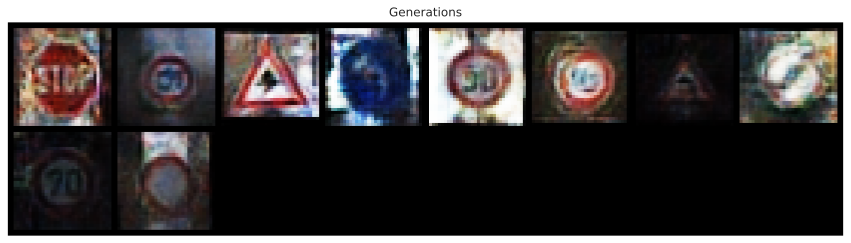

In [29]:
grid = torchvision.utils.make_grid(generated_images.cpu())
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(15,15))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis('off')
print(fixed_classes.resize(5, 2))
plt.show()